In [1]:
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn

from soundsep import open_project

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
project_dir = "/Users/frederictheunissen/Local Data/SocialZF"
project = open_project(Path(project_dir))

## Incremental training of model

Train on 10 minutes, test on next 10 minutes...

1. Define the model (2 layer convolutional network)

2. Define a data loader to train a given time range

3. Train on time range

4. Plot training data and prediction data

In [4]:
from soundsep_prediction.dataset import DatasetParameters, SoundsepAudioDataset
from soundsep_prediction.fit import partial_fit, partial_predict, partial_test
from soundsep_prediction.models import PredictionNetwork
from soundsep_prediction.stft import StftParameters
from torch.utils.data import DataLoader
from torch import nn

segments = pd.read_csv(project_dir + "/_appdata/save/segments.csv")

# Time-frequency scale and temporal resolution of short-time fourier transform (stft)

stft_params = StftParameters()
stft_params.sample_rate = project.sampling_rate
stft_params.half_window = int(10e-3*project.sampling_rate) # 10 ms half window
stft_params.hop = int(5e-3*project.sampling_rate)  # 5 ms sliding window


dataset = SoundsepAudioDataset(
    project_dir=Path(project_dir),
    syllable_table=segments,
    source_names=segments.SourceName.unique(),
    stft_params = stft_params
)

In [5]:
nIn = project.channels
nOut = len(segments.SourceName.unique())

In [6]:
def get_loader(start_index: int, stop_index: int, batch_size: int = 64, shuffle: bool = False, workers: int = 0):
    """Get a torch DataLoader from start_index to stop_index (in project indices)"""
    
    stft_params = StftParameters()
    stft_params.sample_rate = project.sampling_rate
    stft_params.half_window = int(10e-3*project.sampling_rate) # 10 ms half window
    stft_params.hop = int(5e-3*project.sampling_rate)  # 5 ms sliding window
    
    ds = SoundsepAudioDataset(
        project_dir=Path(project_dir),
        syllable_table=segments,
        source_names=segments.SourceName.unique(),
        params=DatasetParameters(
            from_index=start_index,
            until_index=stop_index
        ),
        stft_params = stft_params
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=workers)

In [7]:
dl = get_loader(0, 4100000, 64)

In [8]:
dl.dataset.syllable_table

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags
0,0,7 F,4,1965,5608,"[""DC""]"
1,1,4 M,1,7921,11282,"[""Te""]"
2,2,6 F,3,16612,18858,"[""Te""]"
3,3,7 F,4,18491,26651,"[""Be""]"
4,4,6 F,3,36030,37736,"[""Te""]"
...,...,...,...,...,...,...
269,269,7 F,4,3991039,3993070,"[""Te""]"
270,270,5 M,2,4027508,4028493,"[""Te""]"
271,271,6 F,3,4031643,4033288,"[""Te""]"
272,272,7 F,4,4039828,4041945,"[""Te""]"


In [9]:
model = PredictionNetwork(channels=nIn, output_channels=nOut)

In [10]:
x1, y1 = next(iter(dl))

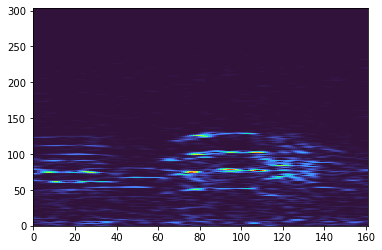

In [11]:
# Display the operation performed on the first layer of the nn: the spectrogram
spec = model.spec(x1)
plt.pcolormesh(spec[60][2], cmap="turbo")

In [13]:
# Checking out the size of the output layer
outputLayer = model.layers(x1)
outLayerN = outputLayer.shape[1]

# Fix the size of last layer in the NN model
model.out_layer = nn.Linear(outLayerN, nOut)

In [14]:
loss = nn.BCEWithLogitsLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.2)

In [15]:
partial_fit(1, model, loss, opt, get_loader(0, 1000000, 64 * 2, shuffle=True))

  0%|          | 0/72 [00:00<?, ?it/s]

0.1526388848030364

In [16]:
y_pred, y_true = partial_predict(model, get_loader(1000000, 1050000, 64 * 2))

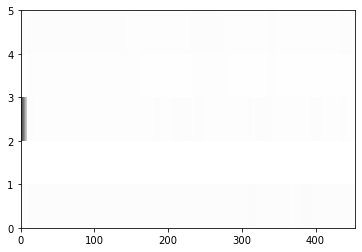

In [17]:
plt.pcolormesh(y_pred.detach().numpy().T, cmap="Greys")
plt.clim(0, 1)

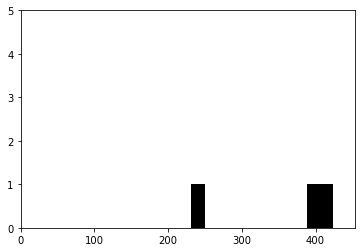

In [19]:
plt.pcolormesh(y_true.detach().numpy().T, cmap="Greys")
plt.clim(0, 1)

In [21]:
partial_test(model, loss, get_loader(1000000, 1050000, 64 * 2))

0.10810134628795842

### Code below is not finished.  
It could be used to test the predictive power of the model as a function of data size.

In [3]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

dt = 44100 * 2
for i in range(60, 80):
    t0 = i * dt
    t1 = (i + 1) * dt
    t2 = (i + 2) * dt

    train_loss = partial_fit(2, model, loss, opt, get_loader(t0, t1, 64, shuffle=True))
    print(f"Loss of {train_loss:.5f} after training")

    # test_loss = partial_test(model, loss, get_loader(t1, t2, 128, workers=4))
    # print(f"Loss of {test_loss:.5f} on next chunk")

    y_pred, y_true = partial_predict(model, get_loader(t1, t2, 64))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(y_pred.detach().numpy().T, cmap="Greys")
    plt.clim(0, 1)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(y_true.detach().numpy().T, cmap="Greys")
    plt.clim(0, 1)
    plt.show()
    plt.close(fig)

    first_window_loss = partial_test(model, loss, get_loader(0, dt, 64))
    print(f"Loss of {first_window_loss:.5f} on first window")

    print()

NameError: name 'torch' is not defined